In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.loadtxt("51Peg_mayorqueloz95.csv", delimiter=",", skiprows=1)

array([[  2.80873, -46.96   ,   3.6    ],
       [  2.95979, -47.39   ,   4.5    ],
       [  3.62695, -19.85   ,   2.9    ],
       [  3.73265, -13.47   ,   2.6    ],
       [  3.90077,  -5.782  ,   3.     ],
       [  4.60753,  49.41   ,   2.2    ],
       [  4.78429,  58.66   ,   2.5    ],
       [  4.90699,  63.2    ,   3.2    ],
       [  5.60503,  45.6    ,   2.7    ],
       [  5.92544,  17.88   ,   3.3    ],
       [ 11.6443 , -45.5    ,   4.7    ],
       [ 11.8378 , -38.98   ,   4.9    ],
       [ 12.6355 ,  27.27   ,   5.2    ],
       [ 12.8664 ,  32.45   ,   6.5    ],
       [ 13.6242 ,  63.38   ,   4.6    ],
       [ 13.8295 ,  54.78   ,   6.2    ],
       [ 14.6428 ,  -1.34   ,   5.4    ],
       [ 14.7229 ,  -5.477  ,   5.5    ],
       [ 14.8161 , -10.73   ,   4.4    ],
       [ 14.9043 , -26.29   ,   7.3    ],
       [ 15.6261 , -50.68   ,   4.6    ],
       [ 15.7467 , -45.78   ,   4.6    ],
       [ 15.8654 , -57.54   ,   5.6    ],
       [ 16.6149 ,  10.56   ,   5.

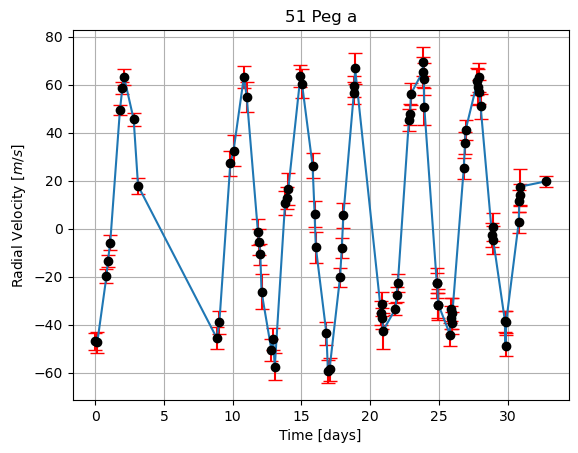

0      0.00000
1      0.15106
2      0.81822
3      0.92392
4      1.09204
        ...   
77    30.79857
78    30.84397
79    30.88947
80    30.92437
81    32.78827
Name: JD, Length: 82, dtype: float64
Initial guesses for P and K are 4.23 and 55.6 respectively


In [8]:
import pandas as pd
from astropy.time import Time

data = pd.read_csv("51Peg_mayorqueloz95.csv")


data['JD']= data['JD'] -  data['JD'][0]



plt.errorbar(data["JD"], data["vrad"], yerr=data["vrad_uncertainty"], fmt='o', color='black', ecolor='red', capsize=5)
plt.plot(data["JD"], data["vrad"])
plt.xlabel("Time [days]")
plt.ylabel("Radial Velocity $[m/s]$")  
plt.title("51 Peg a")
plt.savefig("pdf/51Peg.pdf")
plt.grid()
plt.show()

print(data["JD"])

# Initial guesses for P and K
P_guess=4.23
K_guess=55.6
print(f'Initial guesses for P and K are {P_guess} and {K_guess} respectively')




In [16]:
def chi_squared(data, data_uncertainty, model):
    return np.sum(((data - model)/ data_uncertainty)**2)


def vrad(t,P, K, f0, v0):
    return K * np.sin(2 * np.pi * (t/P - f0)) + v0

delta_P = 1
P_values = np.arange(P_guess - delta_P, P_guess + delta_P, 0.01)
print(P_values)

delta_K = 10
K_values = np.arange(K_guess - delta_K, K_guess + delta_K, 1)


f0_values = np.arange(0, 1, 0.01)

v0_guess = 0
delta_v0 = 10
v0_values = np.arange(v0_guess - delta_v0, v0_guess + delta_v0, 1)


[3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32 3.33 3.34 3.35 3.36
 3.37 3.38 3.39 3.4  3.41 3.42 3.43 3.44 3.45 3.46 3.47 3.48 3.49 3.5
 3.51 3.52 3.53 3.54 3.55 3.56 3.57 3.58 3.59 3.6  3.61 3.62 3.63 3.64
 3.65 3.66 3.67 3.68 3.69 3.7  3.71 3.72 3.73 3.74 3.75 3.76 3.77 3.78
 3.79 3.8  3.81 3.82 3.83 3.84 3.85 3.86 3.87 3.88 3.89 3.9  3.91 3.92
 3.93 3.94 3.95 3.96 3.97 3.98 3.99 4.   4.01 4.02 4.03 4.04 4.05 4.06
 4.07 4.08 4.09 4.1  4.11 4.12 4.13 4.14 4.15 4.16 4.17 4.18 4.19 4.2
 4.21 4.22 4.23 4.24 4.25 4.26 4.27 4.28 4.29 4.3  4.31 4.32 4.33 4.34
 4.35 4.36 4.37 4.38 4.39 4.4  4.41 4.42 4.43 4.44 4.45 4.46 4.47 4.48
 4.49 4.5  4.51 4.52 4.53 4.54 4.55 4.56 4.57 4.58 4.59 4.6  4.61 4.62
 4.63 4.64 4.65 4.66 4.67 4.68 4.69 4.7  4.71 4.72 4.73 4.74 4.75 4.76
 4.77 4.78 4.79 4.8  4.81 4.82 4.83 4.84 4.85 4.86 4.87 4.88 4.89 4.9
 4.91 4.92 4.93 4.94 4.95 4.96 4.97 4.98 4.99 5.   5.01 5.02 5.03 5.04
 5.05 5.06 5.07 5.08 5.09 5.1  5.11 5.12 5.13 5.14 5.15 5.16 5.17 5.18
 5.19 5.2

[ 0.       0.15106  0.81822  0.92392  1.09204  1.7988   1.97556  2.09826
  2.7963   3.11671  8.83557  9.02907  9.82677 10.05767 10.81547 11.02077
 11.83407 11.91417 12.00737 12.09557 12.81737 12.93797 13.05667 13.80617
 13.95047 14.03867 14.92537 15.03547 15.80737 15.95607 16.04527 16.81307
 16.92377 17.03857 17.80497 17.93137 18.04557 18.80637 18.85327 18.89757
 20.78987 20.83607 20.88167 20.91707 21.83037 21.91737 22.00867 22.81387
 22.90577 22.95277 23.80887 23.84207 23.89327 23.92787 24.83867 24.88057
 24.93117 24.96337 25.79737 25.84687 25.89317 25.93627 25.97117 26.80057
 26.89137 26.93807 27.79167 27.83667 27.88427 27.93147 28.02467 28.85317
 28.89647 28.94047 29.79577 29.83917 29.88557 30.79857 30.84397 30.88947
 30.92437 32.78827] [-46.96   -47.39   -19.85   -13.47    -5.782   49.41    58.66    63.2
  45.6     17.88   -45.5    -38.98    27.27    32.45    63.38    54.78
  -1.34    -5.477  -10.73   -26.29   -50.68   -45.78   -57.54    10.56
  12.91    16.4     63.64    60.48    

Searching Periods (P): 100%|██████████| 200/200 [00:52<00:00,  3.79it/s]


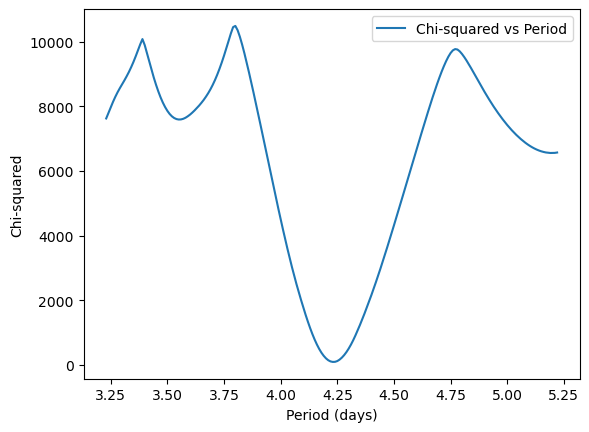

Refining Best Period: 100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


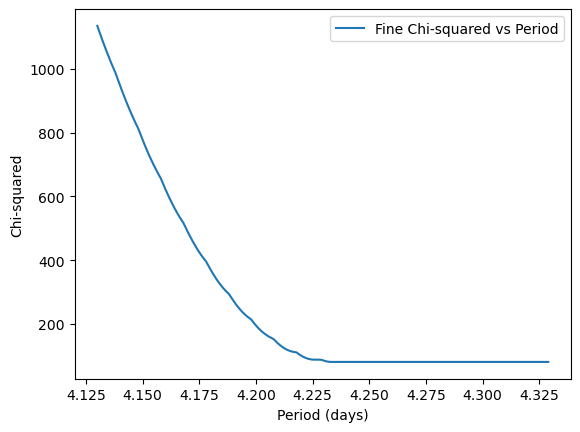

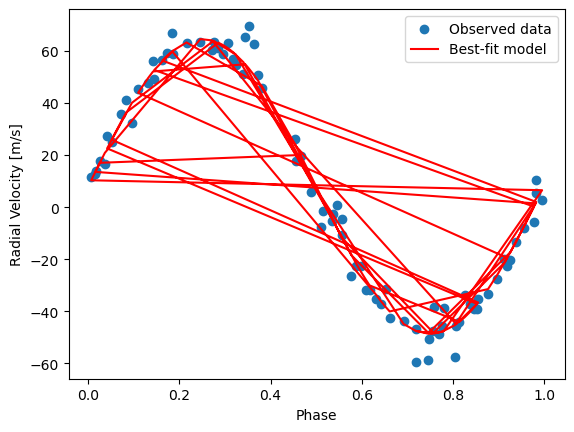

Best-fitting parameters:
Period (P): 4.233000000000014 days
Semi-amplitude (K): 56.6 m/s
Phase offset (f0): 0.28
Systemic velocity (v0): 8 m/s
Minimum Chi-squared: 81.50522781170017


In [19]:
from tqdm import tqdm

# Extract columns from data for convenience
time = data["JD"].values
vrad_obs = data["vrad"].values
vrad_uncertainty = data["vrad_uncertainty"].values

print(time, vrad_obs, vrad_uncertainty)
# Array to store minimum chi-squared values for each P
chi2_min_per_P = []

# Loop over values of P to find the one with the minimum chi-squared
for P in tqdm(P_values, desc="Searching Periods (P)", leave=True):
    chi2_min = float('inf')
    for K in K_values:
        for f0 in f0_values:
            for v0 in v0_values:
                # Calculate the model vrad for current parameters
                model = vrad(time, P, K, f0, v0)
                # Calculate chi-squared for this model
                chi2 = chi_squared(vrad_obs, vrad_uncertainty, model)
                # Check if this chi-squared is the lowest found so far for this P
                if chi2 < chi2_min:
                    chi2_min = chi2
    chi2_min_per_P.append(chi2_min)

# Plot chi-squared as a function of P
plt.plot(P_values, chi2_min_per_P, label="Chi-squared vs Period")
plt.xlabel("Period (days)")
plt.ylabel("Chi-squared")
plt.legend()
plt.show()


# Find the period with the minimum chi-squared value
best_P_index = np.argmin(chi2_min_per_P)
best_P = P_values[best_P_index]

# Refine around best_P by searching in a narrower range
fine_P_values = np.arange(best_P - 0.1, best_P + 0.1, 0.001)
fine_chi2_min_per_P = []
best_K, best_f0, best_v0, min_chi2 = None, None, None, float('inf')

# Refined search with progress bar
for P in tqdm(fine_P_values, desc="Refining Best Period", leave=True):
    for K in K_values:
        for f0 in f0_values:
            for v0 in v0_values:
                model = vrad(time, P, K, f0, v0)
                chi2 = chi_squared(vrad_obs, vrad_uncertainty, model)
                
                if chi2 < min_chi2:
                    min_chi2 = chi2
                    best_P, best_K, best_f0, best_v0 = P, K, f0, v0
    fine_chi2_min_per_P.append(min_chi2)

# Plot fine search results for chi-squared vs. period
plt.plot(fine_P_values, fine_chi2_min_per_P, label="Fine Chi-squared vs Period")
plt.xlabel("Period (days)")
plt.ylabel("Chi-squared")
plt.legend()
plt.show()

# Final plot: observed vs model
phases = (time / best_P - best_f0) % 1  # Phase folding
best_model = vrad(time, best_P, best_K, best_f0, best_v0)

plt.scatter(phases, vrad_obs, label="Observed data")
plt.plot(phases, best_model, label="Best-fit model", color="red")
plt.xlabel("Phase")
plt.ylabel("Radial Velocity [m/s]")
plt.legend()
plt.show()

# Print best-fitting parameters
print("Best-fitting parameters:")
print(f"Period (P): {best_P} days")
print(f"Semi-amplitude (K): {best_K} m/s")
print(f"Phase offset (f0): {best_f0}")
print(f"Systemic velocity (v0): {best_v0} m/s")
print(f"Minimum Chi-squared: {min_chi2}")